Loading data from house_data.csv...

First 5 rows of the dataset:
   RegionID  SizeRank       RegionName RegionType StateName    BaseDate  \
0    102001         0    United States    country       NaN  2025-02-28   
1    394913         1     New York, NY        msa        NY  2025-02-28   
2    753899         2  Los Angeles, CA        msa        CA  2025-02-28   
3    394463         3      Chicago, IL        msa        IL  2025-02-28   
4    394514         4       Dallas, TX        msa        TX  2025-02-28   

   2025-03-31  2025-05-31  2026-02-28  
0         0.1         0.3         0.8  
1         0.3         0.6         0.0  
2        -0.2        -0.1         0.4  
3         0.3         0.7         0.5  
4        -0.3        -0.4        -0.2  

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    89

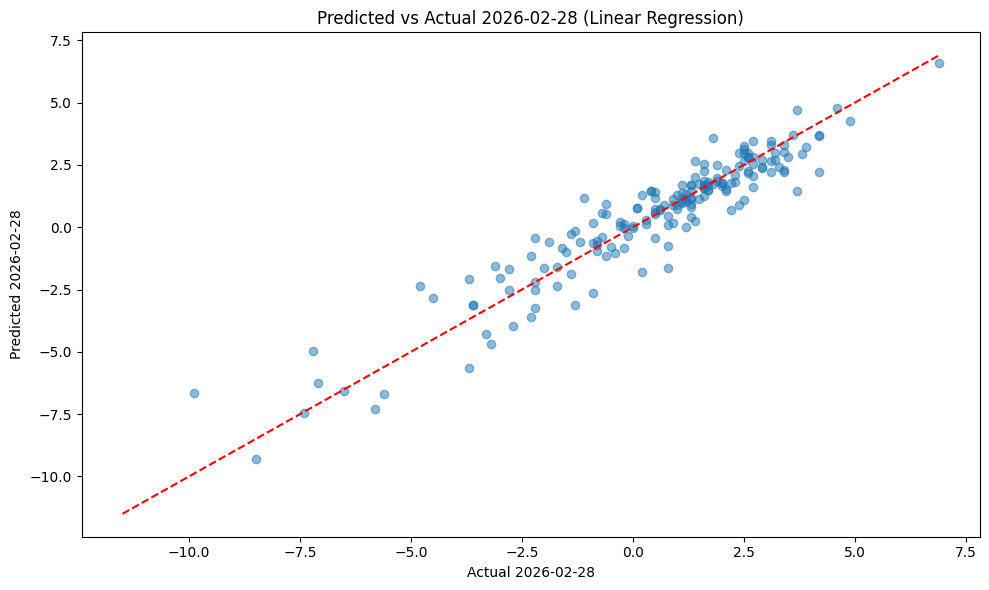

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# 1. Load your existing data
print("Loading data from house_data.csv...")
df = pd.read_csv('house_data.csv')

# 2. Exploratory Data Analysis
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nBasic information about the dataset:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])

# 3. Data Preprocessing
# Identify numeric and categorical columns
print("\nPreprocessing data...")
# Remove the target column (assumed to be 'price') from feature selection
# If your target column has a different name, change it here
target_column = 'price'
if target_column not in df.columns:
    # Try to identify a suitable target column
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Look for columns that might be price-related
    price_related_columns = [col for col in numeric_columns if any(keyword in col.lower() for keyword in 
                                                                ['price', 'value', 'cost', 'worth'])]
    if price_related_columns:
        target_column = price_related_columns[0]
        print(f"Assuming '{target_column}' is the target variable based on column name")
    else:
        # If we can't find a likely price column, use the last numeric column as a fallback
        target_column = numeric_columns[-1]
        print(f"No obvious price column found, using '{target_column}' as the target variable")

# Define features and target
print(f"Using '{target_column}' as the target variable")

# If price column exists, use it as target; otherwise, keep all columns as features
if target_column in df.columns:
    X = df.drop(columns=[target_column])
    y = df[target_column]
else:
    print("Warning: Target column not found. Treating this as time series data.")
    # For time series data, we'll handle differently
    date_columns = [col for col in df.columns if any(str(year) in col for year in range(2015, 2027))]
    
    if date_columns:
        print(f"Detected possible date columns: {date_columns}")
        # Setup for time series restructuring
        id_columns = [col for col in df.columns if col not in date_columns]
        
        # Melt the dataframe to convert date columns to rows
        df_melted = pd.melt(
            df, 
            id_vars=id_columns,
            value_vars=date_columns,
            var_name='Date',
            value_name='ValueChange'
        )
        
        # If possible, convert dates to datetime
        try:
            df_melted['Date'] = pd.to_datetime(df_melted['Date'])
            df_melted['Month'] = df_melted['Date'].dt.month
            df_melted['Year'] = df_melted['Date'].dt.year
        except:
            # If conversion fails, extract year from column name
            df_melted['Year'] = df_melted['Date'].str.extract(r'(\d{4})').astype(float)
            df_melted['Month'] = 1  # Default to January if month not specified
        
        # Use the melted dataframe
        df = df_melted
        # The target is now 'ValueChange'
        target_column = 'ValueChange'
        X = df.drop(columns=[target_column])
        y = df[target_column]
    else:
        print("Could not detect date columns. Assuming last column is the target.")
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        target_column = df.columns[-1]

# Remove any unnecessary columns that wouldn't help with prediction
columns_to_drop = []
for col in X.columns:
    # Drop columns with too many unique values that are likely identifiers
    if X[col].dtype == 'object' and X[col].nunique() > X.shape[0] * 0.5:
        columns_to_drop.append(col)
    # Drop columns with all the same value
    if X[col].nunique() <= 1:
        columns_to_drop.append(col)

# Also drop any obvious ID columns
id_columns = [col for col in X.columns if 'id' in col.lower() or 'region' in col.lower()]
for col in id_columns:
    if col not in columns_to_drop:
        # Only drop if it looks like an ID (many unique values)
        if X[col].nunique() > X.shape[0] * 0.3:
            columns_to_drop.append(col)

print(f"Dropping columns that won't help with prediction: {columns_to_drop}")
X = X.drop(columns=columns_to_drop, errors='ignore')

# Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

print(f"Numerical features: {numerical_cols}")
print(f"Categorical features: {categorical_cols}")

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# 5. Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ], remainder='drop'
)

# 6. Create and train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

best_model = None
best_score = -float('inf')
results = {}

print("\nTraining and evaluating models...")
for name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    
    # Save results
    results[name] = {
        'r2': r2,
        'rmse': rmse,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'pipeline': pipeline
    }
    
    # Print results
    print(f"{name}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Cross-Validation R² Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Update best model
    if cv_scores.mean() > best_score:
        best_score = cv_scores.mean()
        best_model = name

print(f"\nBest model: {best_model} with cross-validation R² score of {best_score:.4f}")

# 7. Save the best model
best_pipeline = results[best_model]['pipeline']
joblib.dump(best_pipeline, 'best_house_price_model.pkl')
print(f"Best model saved as 'best_house_price_model.pkl'")

# 8. Feature importance for the best model (if applicable)
if best_model in ['Random Forest', 'Gradient Boosting']:
    # Get feature names after preprocessing
    feature_names = []
    
    # For numerical features, names stay the same
    feature_names.extend(numerical_cols)
    
    # For categorical features, get the encoded feature names
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    encoded_cat_features = cat_encoder.get_feature_names_out(categorical_cols)
    feature_names.extend(encoded_cat_features)
    
    # Get feature importances
    model = best_pipeline.named_steps['model']
    importances = model.feature_importances_
    
    # Create a DataFrame of feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure sizes match
        'Importance': importances
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title(f'Top 10 Feature Importances ({best_model})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance plot saved as 'feature_importance.png'")

# 9. Visualize predictions vs actual
y_pred = best_pipeline.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel(f'Actual {target_column}')
plt.ylabel(f'Predicted {target_column}')
plt.title(f'Predicted vs Actual {target_column} ({best_model})')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')
print("Prediction plot saved as 'predicted_vs_actual.png'")

# 10. Function to predict for new data
def predict_house_price(model_path, new_data):
    """
    Predict house prices using the trained model
    
    Args:
        model_path: Path to the saved model
        new_data: DataFrame with the same features used during training
        
    Returns:
        Predicted prices
    """
    # Load the model
    model = joblib.load(model_path)
    
    # Make predictions
    predictions = model.predict(new_data)
    
    return predictions

# Example of how to use the prediction function:
print("\nExample of predicting with new data:")
print("To predict house prices for new properties, use code like this:")
print("""
# Load the model
model = joblib.load('best_house_price_model.pkl')

# Create a DataFrame with the same features as the training data
new_data = pd.DataFrame({
    # Fill with appropriate features matching your training data
    # For example:
    'sqft_living': [2000, 2500],
    'bedrooms': [3, 4],
    # Include all required features
})

# Make predictions
predictions = model.predict(new_data)
print(f"Predicted prices: {predictions}")
""")

print("\nModel training and evaluation complete!")